# Data analysis

In this notebook, we will explore the Ames housing dataset and try to predict how much a house will sell for.

In [60]:
import numpy as np
import pandas as pd

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import norm
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, ElasticNetCV, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, RidgeCV

In [61]:
# Read in the data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

Let's start with a preview of the data

In [62]:
pd.set_option('display.max_columns', None)
train['SalePrice'].describe()

count               1,460.00
mean              180,921.20
std                79,442.50
min                34,900.00
25%               129,975.00
50%               163,000.00
75%               214,000.00
max               755,000.00
Name: SalePrice, dtype: float64

In [63]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.00,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.00,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,"2,003.00",RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.00,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.00,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,"1,976.00",RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.00,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.00,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,"2,001.00",RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.00,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.00,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,"1,998.00",Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.00,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.00,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,"2,000.00",RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Correlation plot

In order to see what variables have a real effect on SalePrice, we will construct a correlation matrix. Note that we set vmin = -1 here to make strongly correlated features pop out more.

Note that we are drawing a simplified correlation matrix now. The data has not been cleaned yet and thus a lot of non-numerical features are not included here.

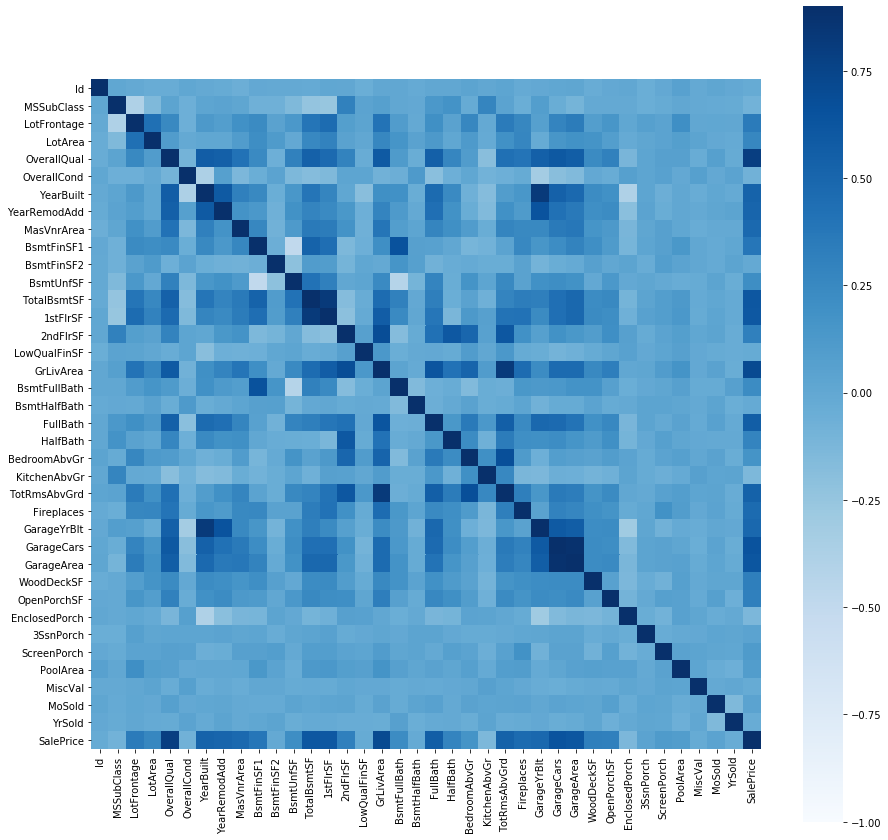

In [64]:
corr = train.corr()
plt.subplots(figsize=(15,15))
sns.heatmap(corr, vmax=0.9, vmin=-1, cmap="Blues", square=True)


## A closer look at SalePrice

Now let's take a look at SalePrice, the value we're going to predict.

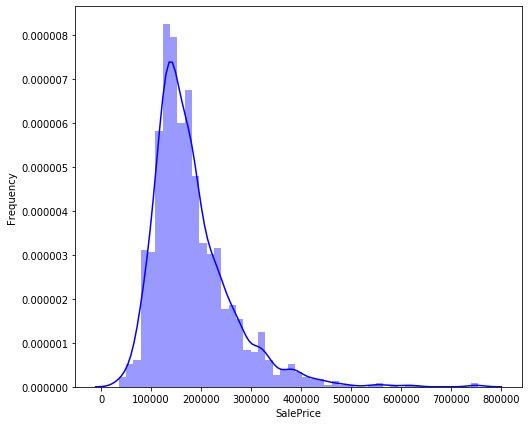

In [65]:
f, ax = plt.subplots(figsize=(8, 7))
sns.distplot(train['SalePrice'], color="b");
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
plt.show()

We can see the data is skewed on the right side. We should aim to have a normally distributed dataset, for this we can use a logaritmic function


 a = 12.02 and b = 0.40



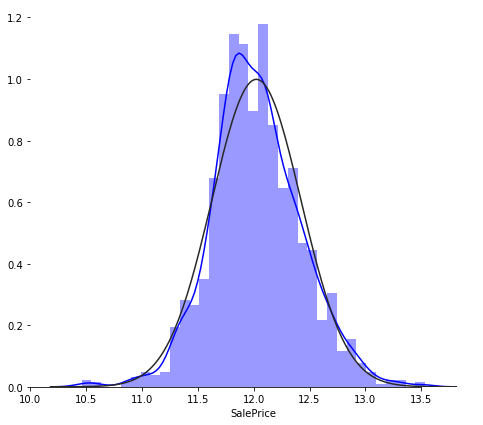

In [66]:
train["SalePrice"] = np.log1p(train["SalePrice"])
f, ax = plt.subplots(figsize=(8, 7))
sns.distplot(train['SalePrice'] , fit=norm, color="b");

# Get the fitted parameters used by the function
(a, b) = norm.fit(train['SalePrice'])
print( '\n a = {:.2f} and b = {:.2f}\n'.format(a, b))

#Now plot the distribution
sns.despine(trim=True, left=True)

plt.show()

Now SalePrice is normally distributed, nice! Now there are still some outliers in the data, we will clean those up

In [67]:
# Remove outliers
train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index, inplace=True)
train.drop(train[(train['GrLivArea']>4500) & (train['SalePrice']<300000)].index, inplace=True)
train.reset_index(drop=True, inplace=True)

# Split features and labels
train_labels = train['SalePrice'].reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features = test

# Combine train & test dataset to apply feature transformation to entire data
all_features = pd.concat([train_features, test_features]).reset_index(drop=True)
all_features.shape

(2917, 80)

## Data cleaning

We will start off by finding missing values.

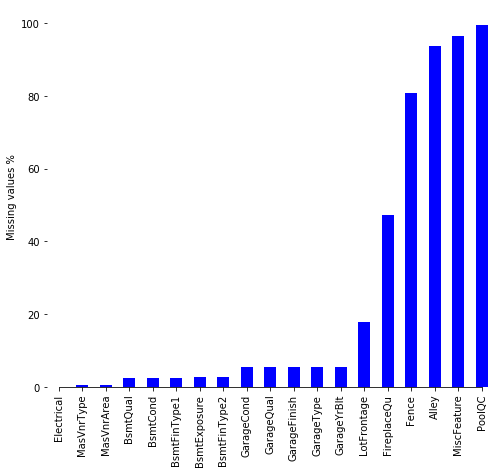

In [68]:
def percent_missing(df):
    data = pd.DataFrame(df)
    df_cols = list(pd.DataFrame(data))
    dict_x = {}
    for i in range(0, len(df_cols)):
        dict_x.update({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100,2)})
    
    return dict_x

missing = percent_missing(all_features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)

# Visualize missing values
f, ax = plt.subplots(figsize=(8, 7))
missing = round(train.isnull().mean()*100,2)
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color="b")
# Tweak the visual presentation
ax.xaxis.grid(False)
ax.set(ylabel="Missing values %")
sns.despine(trim=True, left=True)



We can see that some features are missing a lot of data. Some even get close to 100% missing! We will fill and replace this data to create a usable dataset. 

Using the data description, we can know what values we should fill in.

In [69]:
def process_missing_data(features):
    # From data description: "Functional: Home functionality (Assume typical unless deductions are warranted)"
    features['Functional'] = features['Functional'].fillna('Typ')


    features['Electrical'] = features['Electrical'].fillna("SBrkr")
    features['KitchenQual'] = features['KitchenQual'].fillna("TA")
    features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
    features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
    features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])
    
    features["PoolQC"] = features["PoolQC"].fillna("None")

    # Replacing the missing values with 0, since no garage = no cars in garage
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        features[col] = features[col].fillna(0)
    # Replacing the missing values with None
    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
        features[col] = features[col].fillna('None')
    # NaN values for these categorical basement features, means there's no basement
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        features[col] = features[col].fillna('None')
        
    # Group the by neighborhoods, and fill in missing value by the median LotFrontage of the neighborhood
    features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    # For these last ones, we cannot get more info from the data description and we cannot intuitively fill these values
    # So we replace their missing values with None
    objects = []
    for i in features.columns:
        if features[i].dtype == object:
            objects.append(i)
    features.update(features[objects].fillna('None'))
        
    # Same thing for numerical features
    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric = []
    for i in features.columns:
        if features[i].dtype in numeric_dtypes:
            numeric.append(i)
    features.update(features[numeric].fillna(0))    
    return features

all_features = process_missing_data(all_features)    

Now let's take another look at our data

In [70]:
missing = percent_missing(all_features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
df_miss[0:10]

[('Id', 0.0),
 ('MSSubClass', 0.0),
 ('MSZoning', 0.0),
 ('LotFrontage', 0.0),
 ('LotArea', 0.0),
 ('Street', 0.0),
 ('Alley', 0.0),
 ('LotShape', 0.0),
 ('LandContour', 0.0),
 ('Utilities', 0.0)]

No more missing values, yay!

### Encode categorical features

Numerically encode categorical features because most models can only handle numerical features.

In [71]:
all_features = pd.get_dummies(all_features).reset_index(drop=True)
test = pd.get_dummies(test).reset_index(drop=True)


## Recreate training and test sets

We merged both datasets together so that we could apply data cleaning and feature engineering in one go. Time to split them again!

In [72]:
X = all_features.iloc[:len(train_labels), :]
X_test = all_features.iloc[len(train_labels):, :]
X.shape, train_labels.shape, X_test.shape


((1458, 304), (1458,), (1459, 304))

We only want to use highly correlated features to train the models, so let's prepare a dataframe with only those columns.

In [73]:
tmpdf = X.copy()
tmpdf['SalePrice'] = train['SalePrice']

high_correlation = tmpdf.corr()[['SalePrice']].abs()[:-1] > 0.5
high_corr_rows = high_correlation.loc[high_correlation['SalePrice'] == True].index

mask = pd.Series()
mask = mask.reindex(X.columns)
mask = mask.fillna(False)
mask[high_corr_rows] = True

X = X.loc[:, mask]

X_test = X_test.loc[:, mask]
X_test.head()

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,ExterQual_Gd,ExterQual_TA,Foundation_PConc,KitchenQual_TA,FireplaceQu_None
1458,5,1961,1961,882.00,896,896,1,5,1.00,730.00,0,1,0,1,1
1459,6,1958,1958,"1,329.00",1329,1329,1,6,1.00,312.00,0,1,0,0,1
1460,5,1997,1998,928.00,928,1629,2,6,2.00,482.00,0,1,1,1,0
1461,6,1998,1998,926.00,926,1604,2,7,2.00,470.00,0,1,1,0,0
1462,8,1992,1992,"1,280.00",1280,1280,2,5,2.00,506.00,1,0,1,0,1


## Model training

We will create several models and determine which performs best.

- Cross validation: 12-fold cross-validation. This is a method to estimate the skill of a model

Regularization is designed to penalize model complexity, therefore the higher the alpha, the less complex the model, decreasing the error due to variance (overfit). Alphas that are too high on the other hand increase the error due to bias (underfit). It is important, therefore to choose an optimal alpha such that the error is minimized in both directions.

In [74]:
# Cross validation
scores = {} 

kf = KFold(n_splits=12, random_state=42, shuffle=True)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, train_labels, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

In [75]:
# Set up models

# Ridge

ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))

score = cv_rmse(ridge)
scores['ridge'] = (score.mean(), score.std())

ridge_model_full_data = ridge.fit(X, train_labels)


In [76]:
# Lasso

lasso = Lasso()
parameters = {'alpha': [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20]}
lasso_model = make_pipeline(RobustScaler(), GridSearchCV(lasso, parameters, cv=kf))

score = cv_rmse(lasso_model)
scores['lasso'] = (score.mean(), score.std())

lasso_model_full_data = lasso_model.fit(X, train_labels)

In [77]:
# Elastic

elastic = ElasticNet()
parameters = {'alpha': [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20]}
elastic_model = make_pipeline(RobustScaler(), GridSearchCV(elastic, parameters, cv=kf))

score = cv_rmse(elastic_model)
scores['elastic'] = (score.mean(), score.std())

elastic_model_full_data = elastic_model.fit(X, train_labels)


# Model performance

Now that we have trained our models, we can see which once performs best.

{'ridge': (0.14803334164119394, 0.016083408508940994), 'lasso': (0.14811132624280066, 0.016352757254266218), 'elastic': (0.1480092964003498, 0.01620843865809244)}


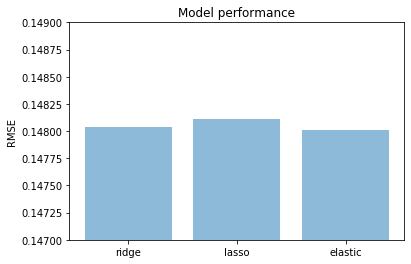

In [78]:
modelTypes = []
performance = []
for i, score in enumerate(scores.keys()):
    modelTypes.append(score)
for i, score in enumerate(scores.values()):
    performance.append(score[0])

print(scores)

y_pos = np.arange(len(modelTypes))

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, modelTypes)
plt.ylabel('RMSE')
plt.title('Model performance')
plt.ylim(ymin=0.147, ymax=0.149)
plt.show()

# Predictions

In [79]:

pd.options.display.float_format = '{:20,.2f}'.format

prediction =  np.floor(np.expm1(elastic_model.predict(X_test)))

result = X_test
result['SalePrice'] = prediction

#result.head()
result['SalePrice'].describe()

count               1,459.00
mean              177,959.16
std                83,932.27
min                62,198.00
25%               123,904.50
50%               157,262.00
75%               209,422.50
max             1,706,173.00
Name: SalePrice, dtype: float64

Now that we are able to make predictions, let's see how good they are by predicting the SalePrice for the training set and comparing that to the actual values.

In [84]:
actual_sale_price = np.expm1(train['SalePrice'])

df_prediction = pd.DataFrame(prediction)


difference = abs(actual_sale_price - df_prediction[0])

#df_prediction.head()

difference.describe()

count               1,458.00
mean               12,008.61
std                13,101.76
min                    18.00
25%                 3,896.75
50%                 8,271.00
75%                15,673.00
max               123,749.00
dtype: float64

Now what would happen if we trained the model using all data instead of just the highly correlated data?

In [81]:
X = all_features.iloc[:len(train_labels), :]
X_test = all_features.iloc[len(train_labels):, :]

# Elastic

elastic = ElasticNet()
parameters = {'alpha': [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20]}
elastic_model = make_pipeline(RobustScaler(), GridSearchCV(elastic, parameters, cv=kf))

score = cv_rmse(elastic_model)
scores['elastic'] = (score.mean(), score.std())

elastic_model_full_data = elastic_model.fit(X, train_labels)

In [83]:


prediction =  np.floor(np.expm1(elastic_model.predict(X)))

df_prediction = pd.DataFrame(prediction)


difference = abs(actual_sale_price - df_prediction[0])

#df_prediction.head()

difference.describe() 

count               1,458.00
mean               12,008.61
std                13,101.76
min                    18.00
25%                 3,896.75
50%                 8,271.00
75%                15,673.00
max               123,749.00
dtype: float64